In [4]:
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/pbs/home/c/cmurray/cluster_likelihood/modules/')
import simulation
import pinocchio_binning_scheme as binning_scheme

import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import corner
import pickle
import scipy.stats as stats
from matplotlib.cm import get_cmap
from torch.distributions import Distribution, Uniform, Normal
import pyccl as ccl
from matplotlib.cm import get_cmap

/pbs/home/c/cmurray/.conda/envs/sbi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Use a colormap that goes from blue to red
cmap = get_cmap('coolwarm')

/tmp/ipykernel_6246/4130027877.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('coolwarm')


In [6]:
import pickle

def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

In [424]:
pinocchio_mock = np.load('/pbs/home/c/cmurray/cluster_likelihood/data/pinocchio_data_vector/data_vector_pinocchio_mock_log_normal_poisson_log_scatter_sigma_lnMwl=0.25.pkl' , allow_pickle= True )
# pinocchio_mock = np.load('/pbs/home/c/cmurray/cluster_likelihood/data/pinocchio_data_vector/data_vector_pinocchio_mock_log_normal_poisson_scatter_sigma_lnMwl=0.25.pkl' , allow_pickle= True )

In [425]:
richness_cents = np.array( [ ( np.array( pinocchio_mock['richness_bins'] ).T[0] + np.array( pinocchio_mock['richness_bins'] ).T[1] )/2. ])[0]
redshift_cents = np.array( [ ( np.array( pinocchio_mock['redshift_bins'] ).T[0] + np.array( pinocchio_mock['redshift_bins'] ).T[1] )/2. ])[0]

In [426]:
pinocchio_mock['redshift_bins']

[[0.2, 0.36],
 [0.36, 0.52],
 [0.52, 0.6799999999999999],
 [0.6799999999999999, 0.8400000000000001],
 [0.8400000000000001, 1.0]]

In [427]:
richness_bins = list(np.array(pinocchio_mock['richness_bins']).T[0])
richness_bins.append( np.array( pinocchio_mock['richness_bins'] ).T[1][-1]  )

redshift_bins = list(np.array( pinocchio_mock['redshift_bins']).T[0])
redshift_bins.append( np.array( pinocchio_mock['redshift_bins'] ).T[1][-1]  )

In [428]:
redshift_bins

[0.2, 0.36, 0.52, 0.6799999999999999, 0.8400000000000001, 1.0]

In [429]:
richness_bins

[19.999999999999996,
 31.697863849222262,
 50.237728630191604,
 79.62143411069944,
 126.19146889603861,
 199.99999999999991]

In [430]:
def dOmega_func( z ):
    return 0.25 * 4 *np.pi

In [328]:
stacked_simulator_pl = simulation.Universe_simulation( 'stacked_counts' ,
                                                        variable_params=['omega_m', 
                                                                         'sigma_8', 
                                                                         'h',
                                                                         'alpha' , 
                                                                         'c' , 
                                                                         'beta',
                                                                         'sigma' ],
                                                        fixed_params={'w_0': -1, 'w_a': 0 } )


stacked_simulator_pl.selection_richness = 0
stacked_simulator_pl.dOmega = dOmega_z

stacked_simulator_pl.sigma_mwl = 0.25
stacked_simulator_pl.include_mwl_measurement_errors = False
stacked_simulator_pl.correlation_mass_evolution = False
stacked_simulator_pl.set_richness_mass_relation( 'constantins model' )
stacked_simulator_pl.set_bins( z_bins = np.arange( 0.2 , 1 , 0.001 ) , 
                               log10m_bins=  np.arange( 14.2 , 15.5 , 0.001))
stacked_simulator_pl.massdef = ccl.halos.massdef.MassDef('vir', 'critical',)
stacked_simulator_pl.halobias_fct = ccl.halos.hbias.tinker10.HaloBiasTinker10(mass_def=stacked_simulator_pl.massdef)
stacked_simulator_pl.f_sky = 0.25
stacked_simulator_pl.hmf = ccl.halos.hmfunc.MassFuncDespali16( mass_def= stacked_simulator_pl.massdef )
stacked_simulator_pl.use_hybrid = False
stacked_simulator_pl.Z_edges_hybrid = binning_scheme.redshift_edges
Z_bin_hybrid = [[stacked_simulator_pl.Z_edges_hybrid[i], stacked_simulator_pl.Z_edges_hybrid[i+1]] for i in range(len(stacked_simulator_pl.Z_edges_hybrid)-1)]
stacked_simulator_pl.poisson_only = False


stacked_simulator_pl.richness_bins = richness_bins
stacked_simulator_pl.redshift_bins = redshift_bins

In [329]:
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711

cosmo = ccl.Cosmology(Omega_c = Omegam_true - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

def compute_Sij_matrix(cosmo, Z_bin_hybrid, f_sky = 1):
    import cluster_abundance_covariance as cl_covar
    CLCovar = cl_covar.Covariance_matrix()
    Sij_partialsky_exact_standard = CLCovar.compute_theoretical_Sij(Z_bin_hybrid, cosmo, 
                                                                f_sky,
                                                                S_ij_type='full_sky_rescaled_approx', 
                                                                path=None)
    return Sij_partialsky_exact_standard

def compute_sigmaij_matrix(cosmo, z_grid, f_sky = 1):
    import cluster_abundance_covariance as cl_covar
    z_grid_center = np.array([(z_grid[i] + z_grid[i+1])/2 for i in range(len(z_grid)-1)])
    CLCovar = cl_covar.Covariance_matrix()
    sigmaij_partialsky_exact_standard = CLCovar.compute_theoretical_sigmaij(z_grid_center, cosmo, f_sky)
    return sigmaij_partialsky_exact_standard

In [330]:


Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711

cosmo = ccl.Cosmology(Omega_c = Omegam_true - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)



In [331]:


have_PySSC = False
if have_PySSC:
    z_grid = np.linspace(0.2, 1, 1000)
    stacked_simulator_pl.sigmaij_SSC = compute_sigmaij_matrix(cosmo, z_grid)/stacked_simulator_pl.f_sky
    save_pickle(stacked_simulator_pl.sigmaij_SSC*stacked_simulator_pl.f_sky, f'/pbs/throng/lsst/users/cpayerne/capish/data/pinocchio_matrix/sigma_ij_full_sky.pkl', )
    
    stacked_simulator_pl.Sij_SSC = compute_Sij_matrix(cosmo, Z_bin_hybrid)/stacked_simulator_pl.f_sky
    save_pickle(stacked_simulator_pl.Sij_SSC*stacked_simulator_pl.f_sky, f'/pbs/throng/lsst/users/cpayerne/capish/data/pinocchio_matrix/S_ij_full_sky.pkl', )
else: 
    S_ij_full_sky = load(f'/pbs/throng/lsst/users/cpayerne/capish/data/pinocchio_matrix/S_ij_full_sky.pkl' )
    stacked_simulator_pl.Sij_SSC = S_ij_full_sky/stacked_simulator_pl.f_sky
    
    sigma_ij_full_sky = load(f'/pbs/throng/lsst/users/cpayerne/capish/data/pinocchio_matrix/sigma_ij_full_sky.pkl' )
    stacked_simulator_pl.sigmaij_SSC = sigma_ij_full_sky/stacked_simulator_pl.f_sky



In [332]:
stacked_simulator_pl.use_hybrid = True

In [333]:
len( richness_cents ) , len( redshift_cents ) 

(5, 5)

In [334]:
full_params = stacked_simulator_pl._get_parameter_set( torch.Tensor([ 0.307 , 0.83 , 0.67 , 2.2 , 3.2 , 0 , 0.5 ]) )
richness, log10mwl , z , mu = stacked_simulator_pl._run_simulation( full_params )

0.3070000112056732 0.04918689886389122 0.6700000166893005 0.8299999833106995
3.200000047683716 0.0 2.200000047683716


In [335]:
log10mwl

array([14.24708898, 14.25979718, 14.12738794, ..., 15.0635978 ,
       15.23537437, 15.36312537])

(array([7.9306e+04, 5.1840e+03, 6.0500e+02, 1.2700e+02, 3.5000e+01,
        2.2000e+01, 6.0000e+00, 4.0000e+00, 4.0000e+00, 2.0000e+00]),
 array([  1.64331583,  78.17459649, 154.70587715, 231.23715781,
        307.76843847, 384.29971913, 460.83099979, 537.36228045,
        613.89356111, 690.42484177, 766.95612243]),
 <BarContainer object of 10 artists>)

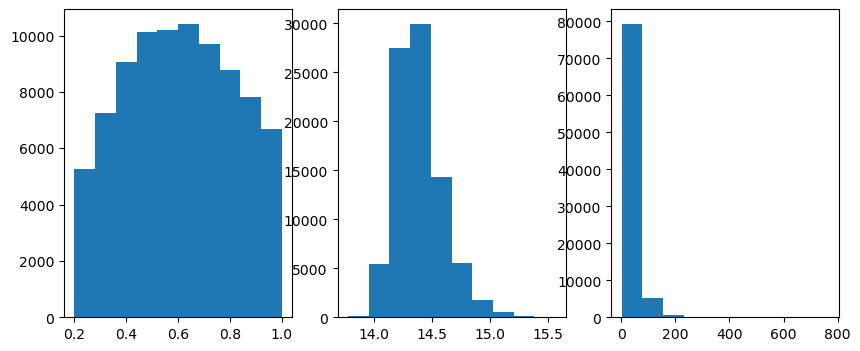

In [336]:
plt.figure( figsize = ( 10 , 4 ))
plt.subplot( 131 )
plt.hist( z )
plt.subplot( 132 )
plt.hist( log10mwl )
plt.subplot( 133 )
plt.hist( richness )


In [337]:
sim_obs = stacked_simulator_pl.run_simulation( torch.Tensor([ 0.307 , 0.83 , 0.67 , 2.2 , 3.2 , 0 , 0.5 ]) )

0.3070000112056732 0.04918689886389122 0.6700000166893005 0.8299999833106995
3.200000047683716 0.0 2.200000047683716


In [338]:
sim_obs = stacked_simulator_pl.run_simulation( ([ 0.307 , 0.83 , 0.67 , 2.2 , 3.2 , 0 , 0.5 ]) )

0.307 0.04918690131432389 0.67 0.83
3.2 0.0 2.2


In [414]:
pinocchio_obs = np.vstack( [ pinocchio_mock['mean_count_richness_redshift'],  pinocchio_mock['mean_log10mass_richness_redshift'] ] ).flatten()

In [409]:
sim_n_clusters = sim_obs[:25].reshape( len( richness_cents ) , len( redshift_cents )  ).T
sim_mwl_mean = sim_obs[25:].reshape( len( richness_cents ), len( redshift_cents ) ).T

In [410]:
sim_n_clusters

array([[3315.721, 3017.78 , 1795.086,  774.932,  265.568],
       [5113.995, 4526.982, 2576.778, 1038.962,  325.04 ],
       [5641.932, 4855.601, 2638.481,  991.913,  279.919],
       [5124.004, 4288.955, 2217.544,  771.564,  197.765],
       [4051.827, 3291.313, 1621.012,  524.007,  120.17 ]])

In [411]:
np.sum( sim_n_clusters ) / np.sum( pinocchio_mock['mean_count_richness_redshift'] )

1.0

/tmp/ipykernel_6246/563058316.py:21: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim( 0 , 7000 )


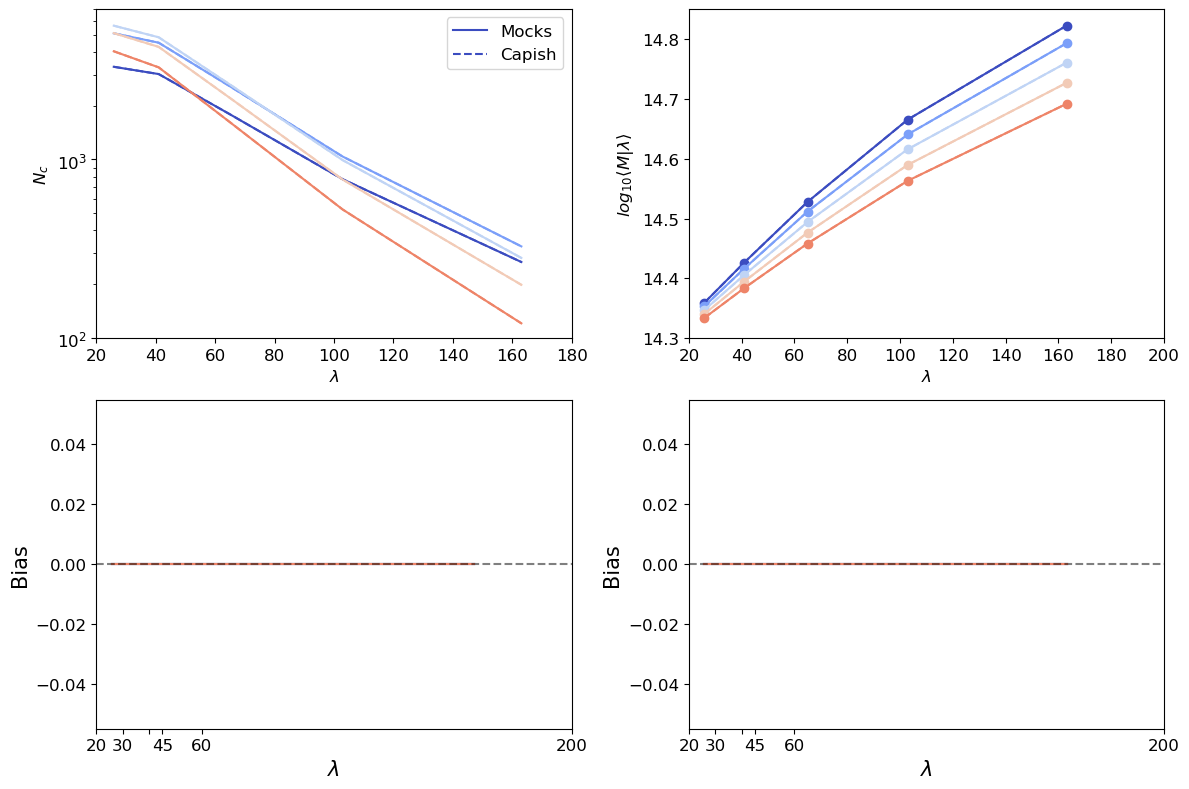

In [412]:
# Set the figure size
plt.figure(figsize=(12, 8))


plt.subplot(221)

for i in range( 0 , len( redshift_cents ) ):
    color = cmap(i /  len( redshift_cents ) ) 
    if i == 0:
        plt.plot( richness_cents , 
                 pinocchio_mock['mean_count_richness_redshift'].T[i] , '-'  , color = color , label = 'Mocks' )#, drawstyle = 'steps-mid')
        plt.plot( richness_cents , sim_n_clusters[i], '--' , color = color , label = 'Capish' )
    else:
        plt.plot( richness_cents , 
                 pinocchio_mock['mean_count_richness_redshift'].T[i] , '-'  , color = color )#, drawstyle = 'steps-mid')
        plt.plot( richness_cents , sim_n_clusters[i], '--' , color = color )

#plt.xscale('log')
plt.yscale('log')
plt.xlim( 20 , 180 )
plt.ylim( 0 , 7000 )
plt.xticks( fontsize = 12 )
plt.yticks( fontsize = 12 )
plt.xlabel(r'$\lambda$' , fontsize = 12 )
plt.ylabel(r'$N_c$' , fontsize = 12 )
plt.legend( fontsize = 12 )

plt.subplot(222)

alpha = 2.2
c = 3.2 
sigma = 0.5
beta = 0

mu = np.log( np.logspace( 14.2 , 14.8 , 10 )/1e14 )

for i in range( 0 , len( redshift_cents ) ):
    color = cmap(i /  len( redshift_cents ) ) 
    plt.plot( richness_cents , 
              ( pinocchio_mock['mean_log10mass_richness_redshift'].T[i] ) , '-' , color = color )# , drawstyle = 'steps-mid')
    plt.plot( richness_cents , sim_mwl_mean[i] , 'o--' , color = color )

#plt.xscale('log')
plt.xlim( 20 , 200 )
plt.ylim( 14.3 , 14.85 )
plt.xticks( fontsize = 12 )
plt.yticks( fontsize = 12 )
plt.xlabel(r'$\lambda$' , fontsize = 12 )
plt.ylabel(r'$log_{10}\left< M | \lambda \right>$' , fontsize = 12 )

plt.subplot(223)

for i in range( 0 , len( redshift_cents ) ):
    color = cmap(i /  len( redshift_cents ) ) 
    plt.plot( richness_cents , 
              ( pinocchio_mock['mean_count_richness_redshift'].T[i]  - sim_n_clusters[i] )/sim_n_clusters[i] , '-'  , color = color )#, drawstyle = 'steps-mid')
    
plt.axhline(0, color='k', linestyle='--', alpha=0.5)
#plt.xscale('log')
plt.xlim(20, 200)
plt.xlabel(r'$\lambda$', fontsize=15)
plt.ylabel('Bias', fontsize=15)
plt.xticks( ticks = [ 20 , 30 , 40 , 45 , 60 , 200 ],
            labels = [ 20 , 30 , None , 45 , 60 , 200 ] , fontsize = 12 )
plt.yticks( fontsize = 12 )
#plt.ylim( -0.3 , 0.3 )

# Subplot 4: Residuals for MWL
plt.subplot(224)

for i in range( 0 , len( redshift_cents ) ):
    color = cmap(i /  len( redshift_cents ) ) 
    plt.plot( richness_cents , 
              ( pinocchio_mock['mean_log10mass_richness_redshift'].T[i] - sim_mwl_mean[i] ) , '-' , color = color )# , drawstyle = 'steps-mid')

plt.axhline(0, color='k', linestyle='--', alpha=0.5)
#plt.xscale('log')
plt.xlim(20, 200)
plt.xlabel(r'$\lambda$', fontsize=15)
plt.ylabel('Bias', fontsize=15)
plt.xticks( ticks = [ 20 , 30 , 40 , 45 , 60 , 200 ],
            labels = [ 20 , 30 , None , 45 , 60 , 200 ] , fontsize = 12 )
plt.yticks( fontsize = 12 )

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

/tmp/ipykernel_6246/563058316.py:21: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim( 0 , 7000 )


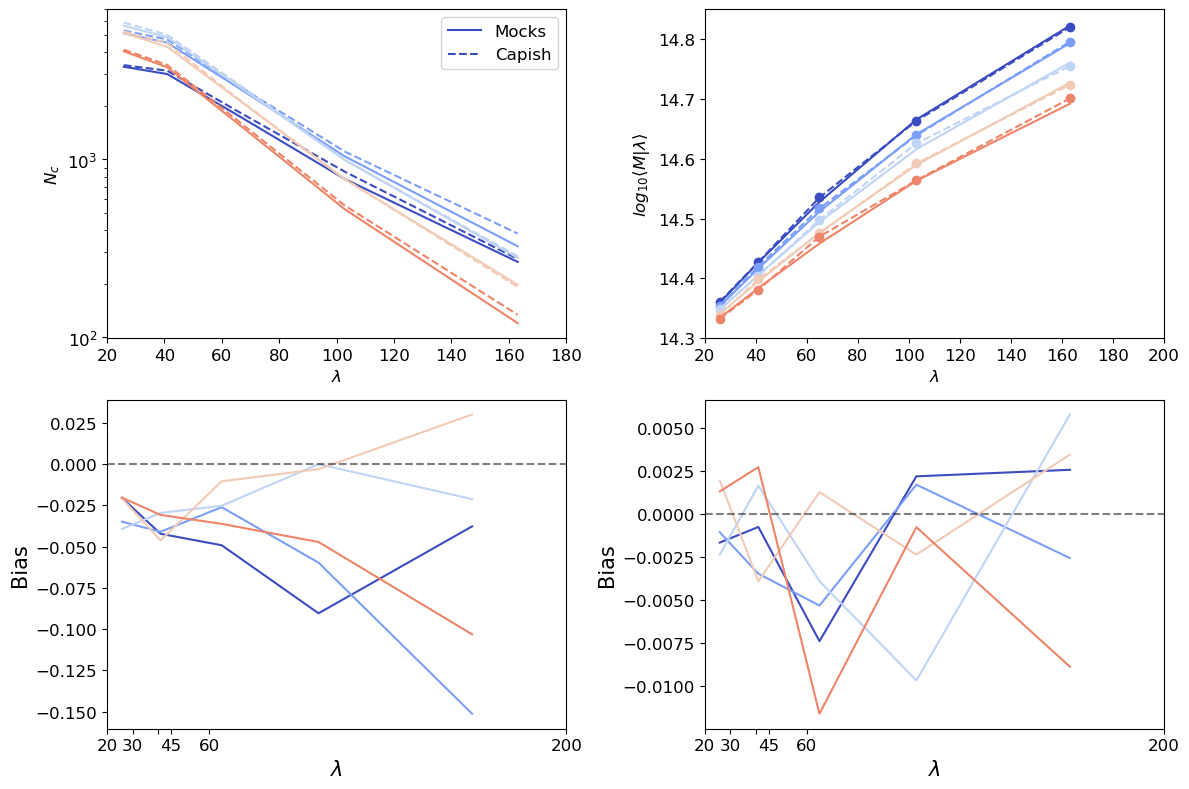

In [343]:
# Set the figure size
plt.figure(figsize=(12, 8))


plt.subplot(221)

for i in range( 0 , len( redshift_cents ) ):
    color = cmap(i /  len( redshift_cents ) ) 
    if i == 0:
        plt.plot( richness_cents , 
                 pinocchio_mock['mean_count_richness_redshift'].T[i] , '-'  , color = color , label = 'Mocks' )#, drawstyle = 'steps-mid')
        plt.plot( richness_cents , sim_n_clusters[i], '--' , color = color , label = 'Capish' )
    else:
        plt.plot( richness_cents , 
                 pinocchio_mock['mean_count_richness_redshift'].T[i] , '-'  , color = color )#, drawstyle = 'steps-mid')
        plt.plot( richness_cents , sim_n_clusters[i], '--' , color = color )

#plt.xscale('log')
plt.yscale('log')
plt.xlim( 20 , 180 )
plt.ylim( 0 , 7000 )
plt.xticks( fontsize = 12 )
plt.yticks( fontsize = 12 )
plt.xlabel(r'$\lambda$' , fontsize = 12 )
plt.ylabel(r'$N_c$' , fontsize = 12 )
plt.legend( fontsize = 12 )

plt.subplot(222)

alpha = 2.2
c = 3.2 
sigma = 0.5
beta = 0

mu = np.log( np.logspace( 14.2 , 14.8 , 10 )/1e14 )

for i in range( 0 , len( redshift_cents ) ):
    color = cmap(i /  len( redshift_cents ) ) 
    plt.plot( richness_cents , 
              ( pinocchio_mock['mean_log10mass_richness_redshift'].T[i] ) , '-' , color = color )# , drawstyle = 'steps-mid')
    plt.plot( richness_cents , sim_mwl_mean[i] , 'o--' , color = color )

#plt.xscale('log')
plt.xlim( 20 , 200 )
plt.ylim( 14.3 , 14.85 )
plt.xticks( fontsize = 12 )
plt.yticks( fontsize = 12 )
plt.xlabel(r'$\lambda$' , fontsize = 12 )
plt.ylabel(r'$log_{10}\left< M | \lambda \right>$' , fontsize = 12 )

plt.subplot(223)

for i in range( 0 , len( redshift_cents ) ):
    color = cmap(i /  len( redshift_cents ) ) 
    plt.plot( richness_cents , 
              ( pinocchio_mock['mean_count_richness_redshift'].T[i]  - sim_n_clusters[i] )/sim_n_clusters[i] , '-'  , color = color )#, drawstyle = 'steps-mid')
    
plt.axhline(0, color='k', linestyle='--', alpha=0.5)
#plt.xscale('log')
plt.xlim(20, 200)
plt.xlabel(r'$\lambda$', fontsize=15)
plt.ylabel('Bias', fontsize=15)
plt.xticks( ticks = [ 20 , 30 , 40 , 45 , 60 , 200 ],
            labels = [ 20 , 30 , None , 45 , 60 , 200 ] , fontsize = 12 )
plt.yticks( fontsize = 12 )
#plt.ylim( -0.3 , 0.3 )

# Subplot 4: Residuals for MWL
plt.subplot(224)

for i in range( 0 , len( redshift_cents ) ):
    color = cmap(i /  len( redshift_cents ) ) 
    plt.plot( richness_cents , 
              ( pinocchio_mock['mean_log10mass_richness_redshift'].T[i] - sim_mwl_mean[i] ) , '-' , color = color )# , drawstyle = 'steps-mid')

plt.axhline(0, color='k', linestyle='--', alpha=0.5)
#plt.xscale('log')
plt.xlim(20, 200)
plt.xlabel(r'$\lambda$', fontsize=15)
plt.ylabel('Bias', fontsize=15)
plt.xticks( ticks = [ 20 , 30 , 40 , 45 , 60 , 200 ],
            labels = [ 20 , 30 , None , 45 , 60 , 200 ] , fontsize = 12 )
plt.yticks( fontsize = 12 )

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [344]:
stacked_simulator_pl.dlog10m

0.0009999999999994458

In [ ]:
 0.307 , 0.83 , 0.67 , 2.2 , 3.2 , 0 , 0.5  

In [384]:
# Define individual priors with correct tensor shape
prior_om = Uniform(torch.tensor([0.25]), torch.tensor([0.4]))
prior_s8 = Uniform(torch.tensor([0.7]), torch.tensor([1.]))
prior_h = Normal(torch.tensor([0.67]), torch.tensor([0.001]))  # Normal prior on h
prior_alpha = Uniform(torch.tensor([2.]), torch.tensor([2.4]))
prior_c = Uniform(torch.tensor([2.0]), torch.tensor([5.0]))
prior_beta = Uniform(torch.tensor([-1.0]), torch.tensor([1.0]))
prior_sigma = Uniform(torch.tensor([0.05]), torch.tensor([1]))

# Combine the priors into a list for processing
priors = [ prior_om, prior_s8, prior_h, prior_alpha, prior_c , prior_beta , prior_sigma ]

In [422]:
n_meas = len( sim_obs )
n_params = 7
n_sims = 1000
1 + ( n_meas - n_params ) / ( n_sims - n_meas )

1.045263157894737

In [434]:
with open('/sps/euclid/Users/cmurray/clusters_likelihood/pinocchio_posterior_calculator.pkl', 'rb') as file:
    pinocchio_posterior_calculator = pickle.load(file)

In [436]:
# # infer posteriors
# pinocchio_posterior_calculator = infer( stacked_simulator_pl.run_simulation , 
#                              priors, 
#                              method = 'SNPE', 
#                              num_simulations = 1000 , 
#                              num_workers = 20 )

In [438]:
nsamples = 100000
# samples_sim = pinocchio_posterior_calculator.sample( (nsamples,), x = sim_obs )
samples_pin = pinocchio_posterior_calculator.sample( (nsamples,), x = pinocchio_obs )

Drawing 100000 posterior samples: 100%|██████████| 100000/100000 [00:05<00:00, 17666.82it/s]


In [439]:
from IPython.display import display, Math

labels_math = ['\Omega_m' , '\sigma_8' , 'h' , r'\alpha_{\lambda}' , 'c', r'\beta' , r'\sigma'  ]

mean_params = []
median_params = []
for i in range( len( labels_math )):
    mcmc = np.percentile( samples_pin.numpy() [:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_math[i])
    display(Math(txt))
    
    mean_params.append( mcmc[1] )
    median_params.append( np.median( mcmc[1]) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

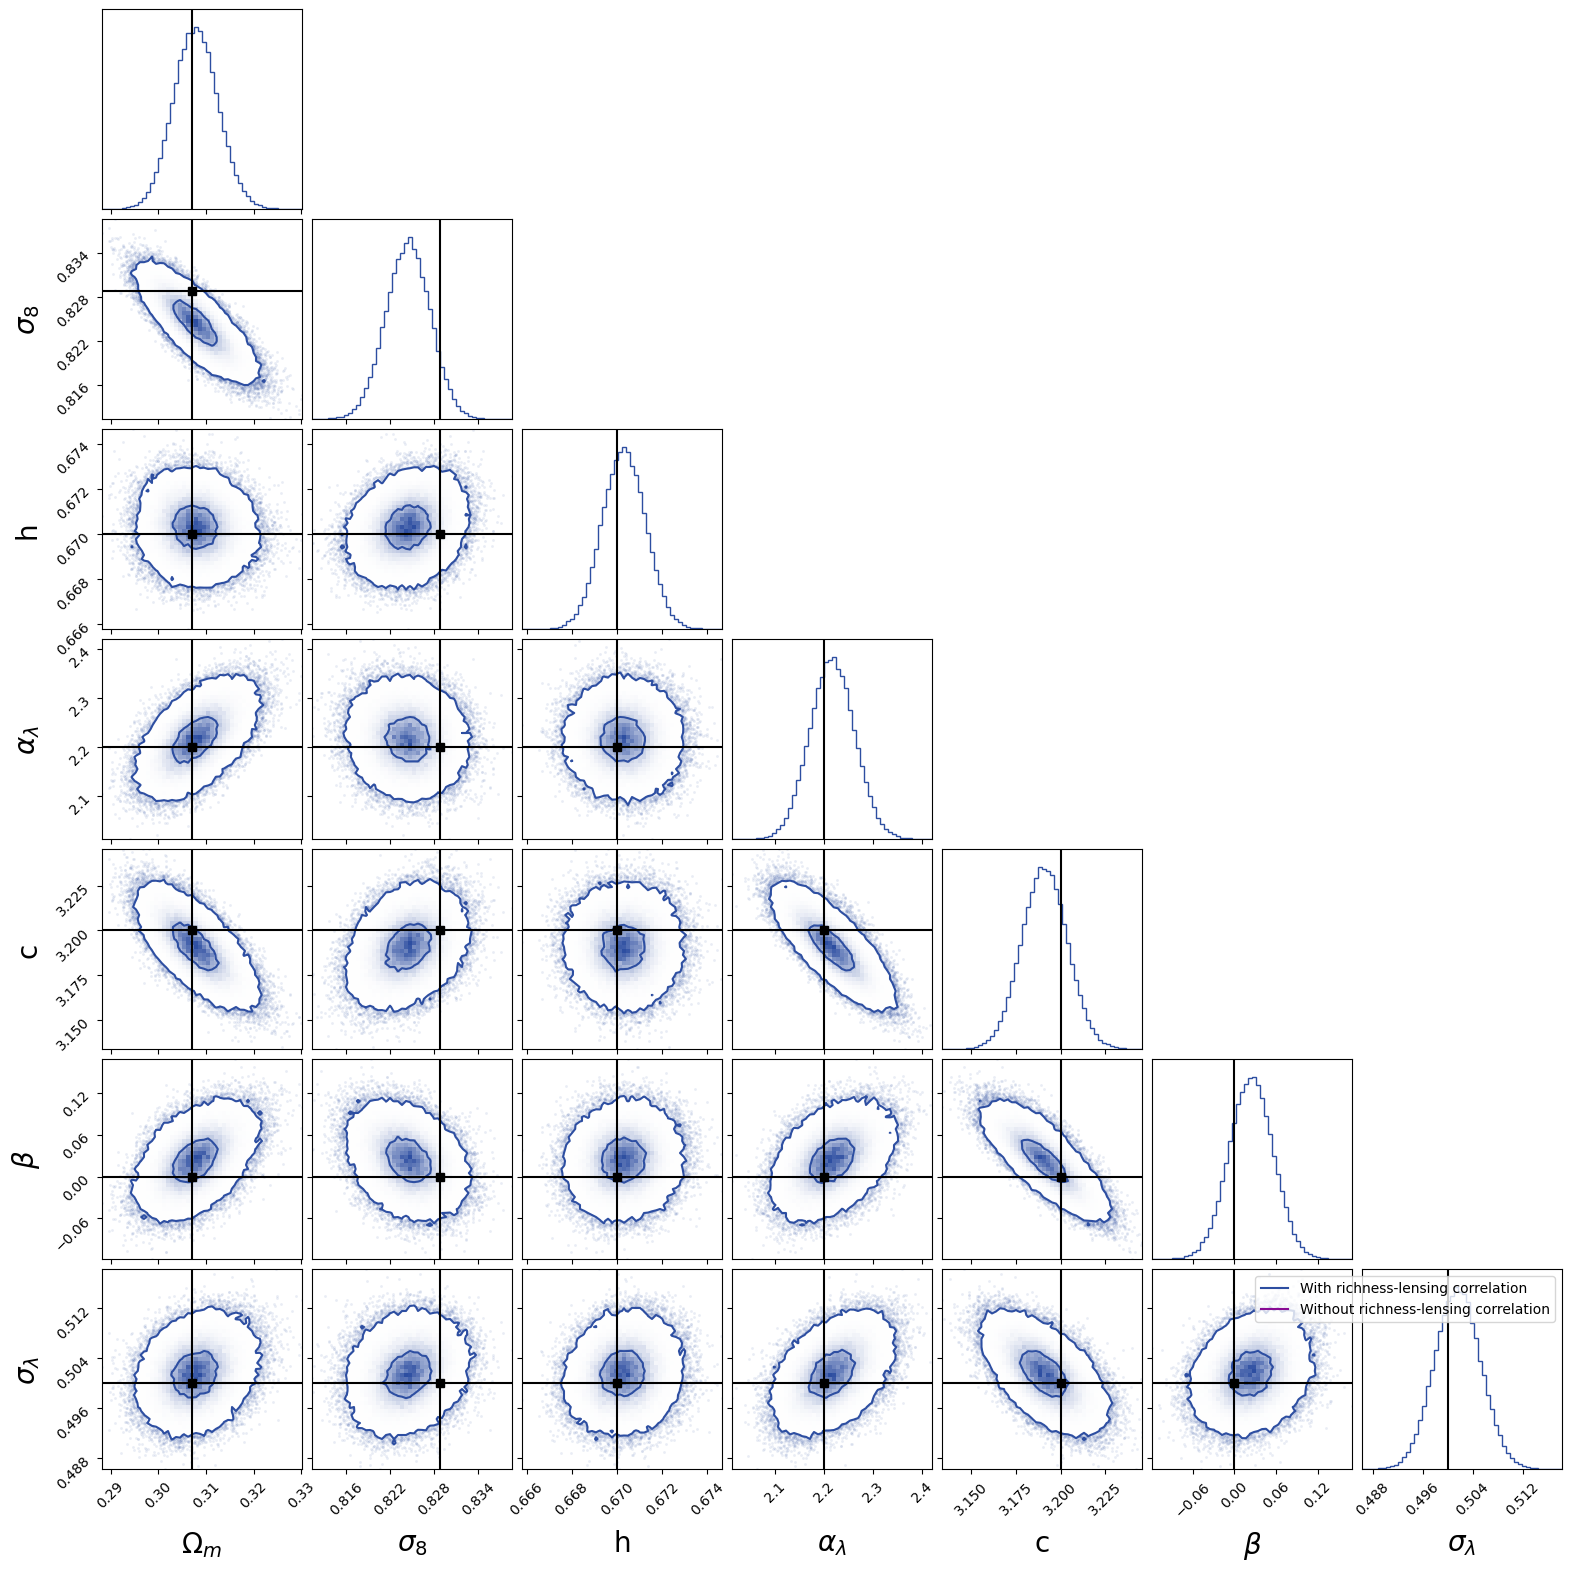

In [441]:
labels = [r'$\Omega_m$' , r'$\sigma_8$' , 'h' , r'$\alpha_{\lambda}$' , 'c', r'$\beta$' , r'$\sigma_{\lambda}$' ]
truths = [ 0.307 , 0.8288 , 0.67 , 2.2 , 3.2 , 0 , 0.5  ]


figure = corner.corner( samples_pin.numpy(), 
                       levels = [ 0.393 , 0.98 ] ,  
                       bins = 50 , 
                       hist_kwargs={'density': True},
                      # range = limits,
                       labels = labels,
                       color ='#2d4ea1',
                       truths = truths,
                       truth_color = 'k',
                       label_kwargs={"fontsize": 20},
                       title_kwargs={"fontsize": 25} )


plt.plot( [  0 ] , [ 0 ] , color = '#2d4ea1' , label = 'With richness-lensing correlation')
plt.plot( [  0 ] , [ 0 ] , color = '#880a94' , label = 'Without richness-lensing correlation')
plt.legend( loc="upper right" )


print()

In [459]:
from IPython.display import display, Math
import numpy as np

labels_math = [r'\Omega_m', r'\sigma_8', 'h', r'\alpha_{\lambda}', 'c', r'\beta', r'\sigma']

mean_params = []
median_params = []

for i in range(len(labels_math)):
    # Compute the MCMC percentiles
    mcmc = np.percentile(samples_pin.numpy()[:, i], [16, 50, 84])
    q = np.diff(mcmc)  # Compute the 1-sigma uncertainties (difference between percentiles)
    
    # Format the string: param - truth: sigma
    param_diff = mcmc[1] - truths[i]
    sigma = param_diff / q[1]
    txt = r"\hat{{\mathrm{{{2}}}}} - \mathrm{{{2}}}: {0:.3f} \, \text{{. Number of }} \sigma \text{{ away}}: {1:.3f}"
    txt = txt.format(param_diff, sigma, labels_math[i])
    
    # Display the result in LaTeX
    display(Math(txt))
    
    # Append mean and median values
    mean_params.append(mcmc[1])
    median_params.append(np.median(samples_pin.numpy()[:, i]))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>